# Nonlinear Sorption Transport (Freundlich Isotherm)

## Key Concept

When contaminants sorb nonlinearly to soil, **high concentrations travel faster** than low concentrations.

### Freundlich Isotherm
$$S = K_f \cdot C^n$$

For **favorable sorption** (n < 1):
- **Retardation**: $R(C) = 1 + \frac{\rho_b}{\theta} K_f n C^{n-1}$
- **Higher C → Lower R → Faster travel**
- **Result**: Sharp front, long tail (asymmetric breakthrough)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gwtransport.advection import infiltration_to_extraction
from gwtransport.residence_time import freundlich_retardation

print("Libraries imported successfully")

Libraries imported successfully


## Setup: Contaminant Pulse

Simulate a **Gaussian contaminant plume** entering groundwater:

In [2]:
# Time setup - optimized to minimize NaN spin-up
n_days = 300
dates = pd.date_range(start="2023-01-01", periods=n_days, freq="D")
tedges = pd.date_range(start="2022-12-31 12:00", periods=n_days + 1, freq="D")

# Flow and aquifer parameters - small pore volume for short residence time
flow = np.full(n_days, 100.0)  # Constant flow [m³/day]
pore_volume = np.array([1000.0])  # Small pore volume = short residence time

# Gaussian contaminant pulse - HIGH concentration for strong nonlinear effects
t = np.arange(n_days)
cin = 100.0 * np.exp(-0.5 * ((t - 10) / 8) ** 2)  # Peak = 100 mg/L (doubled!)

# Output window: start slightly before first arrival, end after last arrival
cout_tedges = pd.date_range(start="2022-12-31 12:00", periods=100, freq="D")  # Slightly extended

print(f"Simulation period: {n_days} days")
print(f"Peak concentration: {cin.max():.1f} mg/L at day {t[np.argmax(cin)]}")
print("Plume width (std): 8 days")
print(f"Mean residence time (no retardation): {pore_volume[0] / flow[0]:.1f} days")
print(f"Output window: {len(cout_tedges) - 1} days")

Simulation period: 300 days
Peak concentration: 100.0 mg/L at day 10
Plume width (std): 8 days
Mean residence time (no retardation): 10.0 days
Output window: 99 days


## Freundlich Retardation

Calculate concentration-dependent retardation:

In [3]:
# Freundlich parameters - strong nonlinearity for sharp peak
freundlich_k = 0.001  # Increased sorption coefficient
freundlich_n = 0.6  # Strong nonlinearity (lower n = sharper peak)
bulk_density = 1600.0  # kg/m³
porosity = 0.35

# Compute retardation for each time bin
retardation_factors = freundlich_retardation(
    concentration=np.maximum(cin, 0.1),  # Avoid division by zero
    freundlich_k=freundlich_k,
    freundlich_n=freundlich_n,
    bulk_density=bulk_density,
    porosity=porosity,
)

# Statistics
peak_idx = np.argmax(cin)
background_idx = np.argmin(np.abs(cin - 0.1))

print(f"Retardation at peak concentration ({cin[peak_idx]:.1f} mg/L): {retardation_factors[peak_idx]:.2f}")
print(f"Retardation at background (0.1 mg/L threshold): {retardation_factors[background_idx]:.2f}")
print(f"Peak travels {retardation_factors[background_idx] / retardation_factors[peak_idx]:.2f}x faster than background")
print(f"Max residence time: {pore_volume[0] * retardation_factors.max() / flow[0]:.1f} days")
print(f"→ Strong nonlinearity: n={freundlich_n} creates sharp breakthrough!")

Retardation at peak concentration (100.0 mg/L): 1.43
Retardation at background (0.1 mg/L threshold): 7.89
Peak travels 5.50x faster than background
Max residence time: 78.9 days
→ Strong nonlinearity: n=0.6 creates sharp breakthrough!


## Transport Comparison

Compare three scenarios:
1. **No retardation** (R=1): Conservative tracer
2. **Nonlinear** (Freundlich): High-C travels fast, low-C travels slow
3. **Linear** (constant R): Average retardation

In [4]:
print("Transport calculations complete")

# 1. No retardation
cout_no_retard = infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volume,
    retardation_factor=1.0,
)

# 2. Nonlinear sorption (Freundlich) - now using unified API with array retardation_factor
cout_freundlich = infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volume,
    retardation_factor=retardation_factors,  # Array enables nonlinear transport
)

# 3. Linear sorption (mean retardation)
R_linear = np.mean(retardation_factors[cin > 1.0])
cout_linear = infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volume,
    retardation_factor=R_linear,
)

print(f"No retardation (R=1): Peak = {np.nanmax(cout_no_retard):.2f} mg/L")
print(f"Freundlich: Peak = {np.nanmax(cout_freundlich):.2f} mg/L")
print(f"Linear (R={R_linear:.2f}): Peak = {np.nanmax(cout_linear):.2f} mg/L")

Transport calculations complete
No retardation (R=1): Peak = 100.00 mg/L
Freundlich: Peak = 99.72 mg/L
Linear (R=1.82): Peak = 99.84 mg/L


## Visualization: Asymmetric Breakthrough

**Key observation**: Freundlich creates a **sharp rising edge** (high-C arrives first) and **long tail** (low-C delayed).

Figure saved to: 06_Freundlich_Sorption_Transport.png


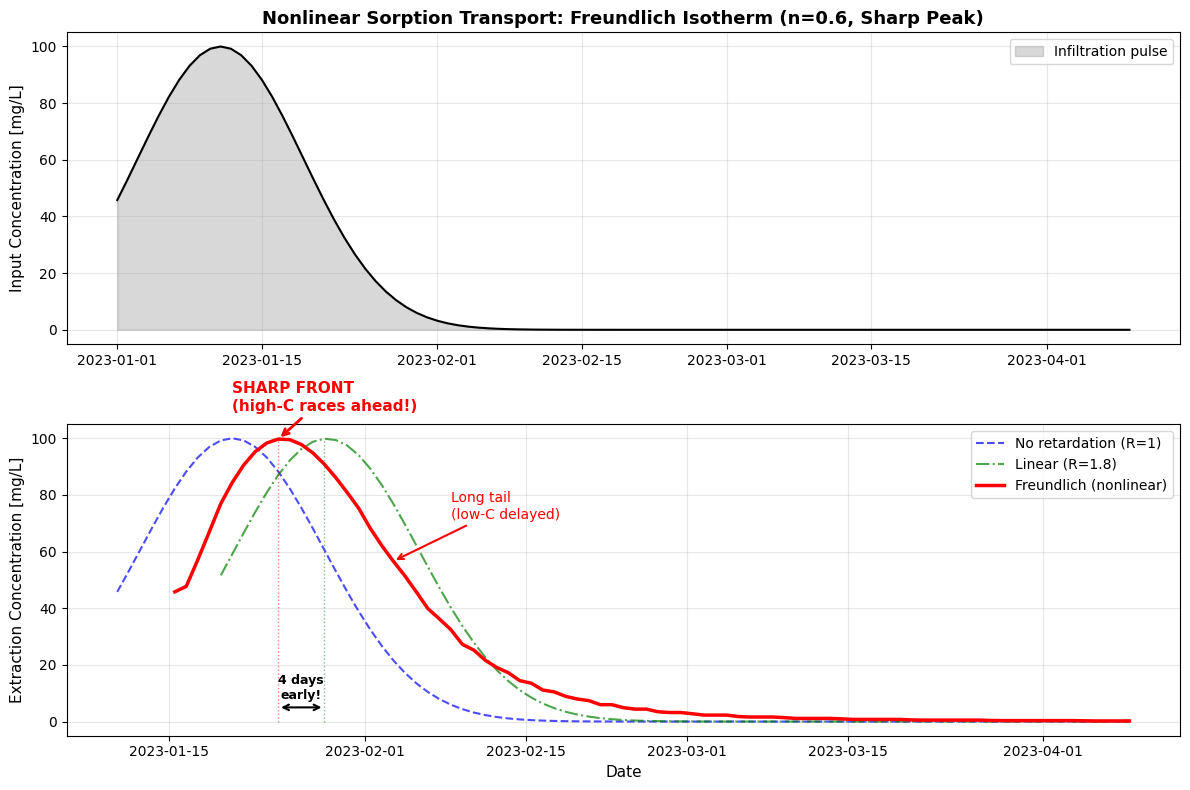

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top: Input concentration (only first 35 days to match output window)
window_size = len(cout_tedges) - 1
ax1.fill_between(dates[:window_size], cin[:window_size], alpha=0.3, color="gray", label="Infiltration pulse")
ax1.plot(dates[:window_size], cin[:window_size], "k-", linewidth=1.5)
ax1.set_ylabel("Input Concentration [mg/L]", fontsize=11)
ax1.set_title("Nonlinear Sorption Transport: Freundlich Isotherm (n=0.6, Sharp Peak)", fontsize=13, fontweight="bold")
ax1.legend(loc="upper right")
ax1.grid(alpha=0.3)

# Bottom: Extraction concentrations
cout_dates = cout_tedges[:-1]  # Bin centers

ax2.plot(cout_dates, cout_no_retard, "b--", label="No retardation (R=1)", linewidth=1.5, alpha=0.7)
ax2.plot(cout_dates, cout_linear, "g-.", label=f"Linear (R={R_linear:.1f})", linewidth=1.5, alpha=0.7)
ax2.plot(cout_dates, cout_freundlich, "r-", label="Freundlich (nonlinear)", linewidth=2.5)

# Annotations - adaptive to data range
peak_idx_freundlich = np.nanargmax(cout_freundlich)
peak_idx_linear = np.nanargmax(cout_linear)
n_cout = len(cout_freundlich)

# Sharp front annotation
if peak_idx_freundlich >= 3:
    ax2.annotate(
        "SHARP FRONT\n(high-C races ahead!)",
        xy=(cout_dates[peak_idx_freundlich], cout_freundlich[peak_idx_freundlich]),
        xytext=(cout_dates[max(0, peak_idx_freundlich - 4)], cout_freundlich[peak_idx_freundlich] + 10),
        arrowprops={"arrowstyle": "->", "color": "red", "lw": 2},
        fontsize=11,
        color="red",
        fontweight="bold",
    )

# Show early arrival vs linear
if peak_idx_freundlich < peak_idx_linear:
    ax2.plot(
        [cout_dates[peak_idx_freundlich], cout_dates[peak_idx_freundlich]],
        [0, cout_freundlich[peak_idx_freundlich]],
        "r:",
        linewidth=1,
        alpha=0.5,
    )
    ax2.plot(
        [cout_dates[peak_idx_linear], cout_dates[peak_idx_linear]],
        [0, cout_linear[peak_idx_linear]],
        "g:",
        linewidth=1,
        alpha=0.5,
    )
    ax2.annotate(
        "",
        xy=(cout_dates[peak_idx_linear], 5),
        xytext=(cout_dates[peak_idx_freundlich], 5),
        arrowprops={"arrowstyle": "<->", "color": "black", "lw": 1.5},
    )
    mid_idx = (peak_idx_freundlich + peak_idx_linear) // 2
    ax2.text(
        cout_dates[mid_idx],
        8,
        f"{peak_idx_linear - peak_idx_freundlich} days\nearly!",
        ha="center",
        fontsize=9,
        fontweight="bold",
    )

# Long tail annotation
tail_start = min(peak_idx_freundlich + 10, n_cout - 1)
if tail_start < n_cout and tail_start + 5 < n_cout:
    ax2.annotate(
        "Long tail\n(low-C delayed)",
        xy=(cout_dates[tail_start], cout_freundlich[tail_start]),
        xytext=(cout_dates[min(tail_start + 5, n_cout - 1)], cout_freundlich[tail_start] + 15),
        arrowprops={"arrowstyle": "->", "color": "red", "lw": 1.5},
        fontsize=10,
        color="red",
    )

ax2.set_ylabel("Extraction Concentration [mg/L]", fontsize=11)
ax2.set_xlabel("Date", fontsize=11)
ax2.legend(loc="upper right", fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("06_Freundlich_Sorption_Transport.png", dpi=150, bbox_inches="tight")
# plt.close()

print("Figure saved to: 06_Freundlich_Sorption_Transport.png")

## Key Takeaways

✅ **Nonlinear sorption creates asymmetric breakthrough curves**
- Sharp front (high-C travels fast)
- Long tail (low-C travels slow)

✅ **Linear models (constant R) miss this behavior**
- Underpredict early arrival
- Overpredict peak concentration
- Underpredict tail duration

✅ **Implementation Notes**
- Use `infiltration_to_extraction()` with array `retardation_factor` for nonlinear sorption
- When `retardation_factor` is an array (one value per time bin), the function automatically uses the nonlinear algorithm
- When `retardation_factor` is a scalar, it uses the standard linear sorption algorithm

✅ **Applications**:
- Organic contaminant transport
- Heavy metal migration
- Pesticide fate and transport
- Pharmaceutical transport in groundwater